**Downloading and Initializing Required Files**

In [ ]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip install soundfile
!pip install librosa
!pip install tqdm

In [ ]:
# imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets.utils import download_url as download_url
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
import tarfile
import csv
import soundfile
import librosa
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Downloads dataset to google drive, will have to manually rename the file to UrbanSound8K.tar.gz
dataset_url = 'https://goo.gl/8hY5ER'
download_url(dataset_url, "/tmp/gdrive/My Drive/urban_data/")

KeyboardInterrupt: ignored

In [ ]:
with tarfile.open("/tmp/gdrive/MyDrive/urban_data/UrbanSound8K.tar.gz", mode = 'r:gz') as tar:
    tar.extractall(path='/tmp/gdrive/MyDrive/urban_data/data')

**Formatting and Cleaning Data**

In [ ]:
with open("/content/gdrive/MyDrive/urban_data/data/UrbanSound8K/metadata/UrbanSound8K.csv") as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        print(row)

In [ ]:
# explains the different categories of data available
data_dir = "/content/gdrive/MyDrive/urban_data/data/UrbanSound8K"
print(os.listdir(data_dir))
print(os.listdir(data_dir+"/metadata"))
print(os.listdir(data_dir+"/audio"))

['.DS_Store', 'audio', 'FREESOUNDCREDITS.txt', 'metadata', 'UrbanSound8K_README.txt']
['.DS_Store', 'UrbanSound8K.csv']
['.DS_Store', 'fold1', 'fold10', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9']


In [ ]:
# viewing the information about each song from the dataset using pandas
csvData = pd.read_csv(data_dir+"/metadata/UrbanSound8K.csv")
print(len(list(csvData.iloc))) # total number of songs we are dealing with
print(csvData.iloc[0]) # exmaple of a an object in the csv

8732
slice_file_name    100032-3-0-0.wav
fsID                         100032
start                             0
end                        0.317551
salience                          1
fold                              5
classID                           3
class                      dog_bark
Name: 0, dtype: object


**Defining the Dataset**

In [ ]:
torchaudio.set_audio_backend("sox_io")
torchaudio.get_audio_backend()

'sox_io'

In [ ]:
soundfile.available_subtypes('FLAC')

{'PCM_16': 'Signed 16 bit PCM',
 'PCM_24': 'Signed 24 bit PCM',
 'PCM_S8': 'Signed 8 bit PCM'}

In [ ]:
class UrbanSounds(Dataset):
    def __init__(self, csv_file_path, folders_file_path, seed=10, sample_size = 176400):
        """
        :param csv_file_path: Path to the csv file with metadata about sounds
        :param folders_file_path: Path to directory housing folders with
        :param seed: Specifies which folder number to be used to test data-performance
        :param sample_size: Specifies how big the audio samples should be (bigger is better, but requires more time and data)
        """
        self.urban_sounds_frame = pd.read_csv(csv_file_path)
        self.folders_file_path = folders_file_path

        self.sound_id_name = {
            0: "air_conditioner",
            1: "car_horn",
            2: "children_playing",
            3: "dog_bark",
            4: "drilling",
            5: "engine_idling",
            6: "gun_shot",
            7: "jackhammer",
            8: "siren",
            9: "street_music"
        }

        self.sample_size = sample_size
        self.seed = seed

        self.train_ds = []
        self.test_ds = []

    def __getitem__(self, index):
        # Setup iloc
        slicer = self.urban_sounds_frame.iloc
        wav_unit = slicer[index]

        # Find the folder number, name, and classifcation associated with the index
        wav_name = wav_unit["slice_file_name"]
        wav_fold = wav_unit["fold"]
        wav_classid = wav_unit["classID"]
        wav_classname = self.sound_id_name[wav_classid]

        # Get the wav file using the path
        wav_file = self.folders_file_path + "/fold"+str(wav_fold)+"/"+wav_name

        # Convert bit depth to 32 bit
        data, samplerate = librosa.load(wav_file, 44100, mono=True)
        sound = torch.from_numpy(data)

        # Convert the wav file to a tensor
        # tensors, default_sample_rate = torchaudio.load(wav_file)
        # print(samplerate, tensors.shape)

        # OPTIONAL MIXING (Uncomment for the mixing to work, otherwise expect 2 channel audio)
        # sound = torch.mean(tensors, dim=0, keepdim=True)

        # Fix all wav files to 176400 samples
        padded_data = torch.zeros(176400) #tempData accounts for audio clips that are too short

        if sound.numel() < 176400:
            padded_data[:sound.numel()] = sound[:]
        else:
            padded_data[:] = sound[:176400]
        

        final_data = torch.zeros(self.sample_size)
        every_n = 176400 // self.sample_size

        count = 0
        for i in range(self.sample_size):
            final_data[i] = padded_data[count]
            count += every_n
        
        return (final_data, wav_fold, wav_classid)
    
    def set_train_test(self):
        for i in tqdm(range(8372)):
            (tensor, folder, classID) = self[i]
            if int(folder) == self.seed:
                self.test_ds.append((tensor, classID))
            else:
                self.train_ds.append((tensor, classID))

    def __len__(self):
        return len(self.urban_sounds_frame)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
dataset = UrbanSounds(csv_file_path="/tmp/gdrive/MyDrive/urban_data/data/UrbanSound8K/metadata/UrbanSound8K.csv", folders_file_path="/tmp/gdrive/MyDrive/urban_data/data/UrbanSound8K/audio", sample_size=32000)
# dataset.set_train_test()

In [ ]:
import pickle
with open('train_ds.pkl', 'wb') as f:
    pickle.dump(dataset.train_ds, f)
with open('test_ds.pkl', 'wb') as f:
    pickle.dump(dataset.test_ds, f)

In [ ]:
import pickle
dataset.train_ds = None
with open('train_ds.pkl', 'rb') as f:
    dataset.train_ds = pickle.load(f)

dataset.test_set = None
with open('test_ds.pkl', 'rb') as f:
    dataset.test_ds = pickle.load(f)

In [ ]:
print(len(dataset.train_ds))
print(len(dataset.test_ds))

batch_size = 128
train_dl = DataLoader(dataset.train_ds, batch_size, shuffle=True)
test_dl = DataLoader(dataset.test_ds, batch_size*2)

7583
789


In [ ]:
class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 2, 1)
        
class Unsqueeze(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            Unsqueeze(),

            nn.Conv1d(1, 64, 80, 5),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(64, 64, 3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(64, 128, 3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, 3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(128, 256, 3),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, 3),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, 3),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(256, 512, 3),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 512, 3),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.AvgPool1d(19),
            Permute(),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=2)
            )
    def forward(self, xb):
        return self.network(xb)



In [ ]:
model = Net()
model.to(device)

Net(
  (network): Sequential(
    (0): Unsqueeze()
    (1): Conv1d(1, 64, kernel_size=(80,), stride=(5,))
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (16): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.1)

In [ ]:
def train(model, epoch):
    model.train() # change the mode of the model
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        data = data.requires_grad_() #set requires_grad to True for training
        output = model(data)
        output = output.permute(1, 0, 2) #original output dimensions are batchSizex1x10 
        loss = F.nll_loss(output[0], target) #the loss functions expects a batchSizex10 input
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_dl.dataset),
        100. * batch_idx / len(train_dl), loss))

In [ ]:
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_dl:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_dl.dataset),
        100. * correct / len(test_dl.dataset)))
    return (1. * correct / len(test_dl.dataset))

In [ ]:
log_interval = 20
counter = 0
history = []
for epoch in range(300):
    if epoch > 99 and epoch % 100 == 0:
        print((epoch//100), "round of training complete. Dividing learning rate by 10")
    scheduler.step()
    train(model, epoch)
    acc = test(model, epoch)

    history.append((epoch, acc * 100))
    

Train Epoch: 0 [1829/7583 (98%)]	Loss: 0.396829

Test set: Accuracy: 524/789 (66%)

Train Epoch: 1 [1829/7583 (98%)]	Loss: 0.837211

Test set: Accuracy: 457/789 (58%)

Train Epoch: 2 [1829/7583 (98%)]	Loss: 0.583222

Test set: Accuracy: 454/789 (58%)

Train Epoch: 3 [1829/7583 (98%)]	Loss: 0.533040

Test set: Accuracy: 473/789 (60%)

Train Epoch: 4 [1829/7583 (98%)]	Loss: 0.932074

Test set: Accuracy: 384/789 (49%)

Train Epoch: 5 [1829/7583 (98%)]	Loss: 0.627020

Test set: Accuracy: 476/789 (60%)

Train Epoch: 6 [1829/7583 (98%)]	Loss: 0.512309

Test set: Accuracy: 478/789 (61%)

Train Epoch: 7 [1829/7583 (98%)]	Loss: 0.699526

Test set: Accuracy: 435/789 (55%)

Train Epoch: 8 [1829/7583 (98%)]	Loss: 0.735817

Test set: Accuracy: 458/789 (58%)

Train Epoch: 9 [1829/7583 (98%)]	Loss: 0.626046

Test set: Accuracy: 445/789 (56%)

Train Epoch: 10 [1829/7583 (98%)]	Loss: 0.520502

Test set: Accuracy: 408/789 (52%)

Train Epoch: 11 [1829/7583 (98%)]	Loss: 0.268406

Test set: Accuracy: 508/7

No handles with labels found to put in legend.


[(0, 66.41318124207858), (1, 57.92141951837769), (2, 57.54119138149556), (3, 59.949302915082384), (4, 48.669201520912544), (5, 60.329531051964516), (6, 60.5830164765526), (7, 55.13307984790875), (8, 58.04816223067174), (9, 56.40050697084917), (10, 51.71102661596958), (11, 64.38529784537388), (12, 52.59822560202788), (13, 69.20152091254754), (14, 55.51330798479087), (15, 64.63878326996198), (16, 60.07604562737643), (17, 48.92268694550063), (18, 56.27376425855514), (19, 62.61089987325729), (20, 45.373891001267424), (21, 49.68314321926489), (22, 57.66793409378961), (23, 51.20405576679341), (24, 62.864385297845374), (25, 49.93662864385298), (26, 61.21673003802282), (27, 50.44359949302915), (28, 54.62610899873257), (29, 55.51330798479087), (30, 53.73891001267427), (31, 59.442332065906214), (32, 64.38529784537388), (33, 56.527249683143225), (34, 65.65272496831433), (35, 60.329531051964516), (36, 56.7807351077313), (37, 53.35868187579214), (38, 57.16096324461344), (39, 60.96324461343473), (40

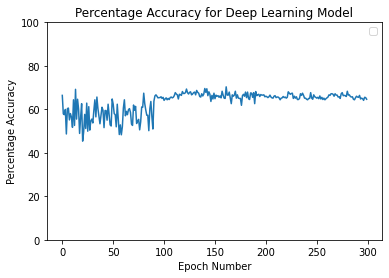

In [ ]:
import matplotlib.pyplot as plt
plt.clf()
print(history)
y_val = [x[1] for x in history]
x_val = [x[0] for x in history]
plt.plot(y_val)

plt.xlabel('Epoch Number')
plt.ylabel('Percentage Accuracy')
plt.ylim(0, 100)
plt.title('Percentage Accuracy for Deep Learning Model')
plt.legend()
plt.show()

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
torch.save(model.state_dict(), 'deep_net.pth')

In [ ]:
# Loading model
# model = to_device(Net(), device)
# model.load_state_dict(torch.load('cifar10-cnn.pth'))